In [2]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import cv2
from torchvision.utils import save_image

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
import albumentations as A

from tqdm import tqdm

In [3]:
# 이미지 path 저장

img_dir = glob.glob('/opt/ml/input/data/train/images/*')

class_num = 18
classes = [[] for _ in range(class_num)]

for path in img_dir:
    # gender와 age에 따라 class 설정
    info = path.split('/')[-1].split('_')
    gender, age = info[1], int(info[3])
    c = 0
    if gender == 'female':
        c += 3
        
    if 30 <= age and age < 60:
        c += 1
    elif 60 <= age:
        c += 2
    
    new_c = c
    img_paths = glob.glob(os.path.join(path, '*'))
    for img_path in img_paths:
        c = new_c
        if 'incorrect' in img_path:
            c += 6
        elif 'normal' in img_path:
            c += 12
        classes[c].append(img_path)

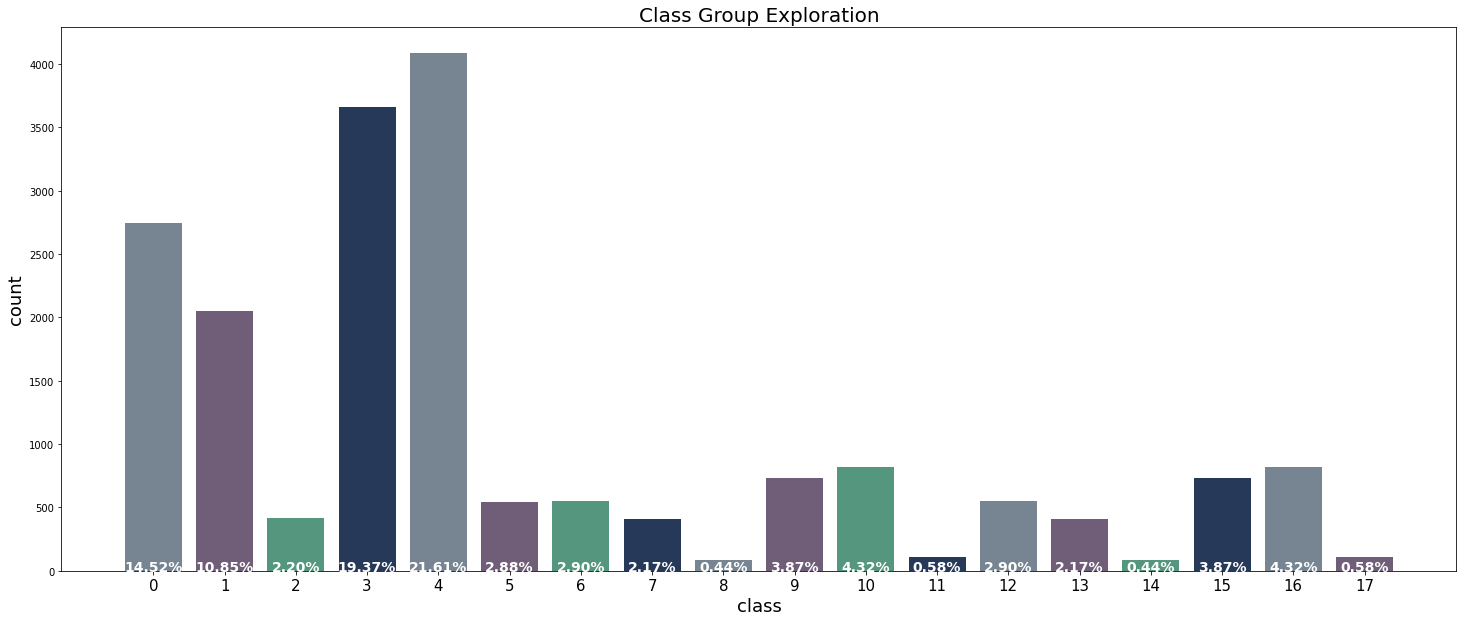

In [8]:
class_num = 18
index = []
count = []
colors = ['#768591', '#705E78', 
          '#55967e', '#263959']
for i in range(class_num):
    index.append(i)
    count.append(len(classes[i]))

plt.figure(figsize=(25, 10))
plt.bar(index, count, color=colors)
plt.title('Class Group Exploration', fontsize=20)
plt.xlabel('class', fontsize=18)
plt.ylabel('count', fontsize=18)
plt.xticks(index, fontsize=15)

count = np.array(count)
counts_pct = [f'{elem * 100:.2f}%' for elem in count / sum(count)]
#counts_pct = [f'{elem}' for elem in count]
for i, v in enumerate(counts_pct):
    plt.text(i, 0.1, v, horizontalalignment = 'center', size = 14, color = 'w', fontweight = 'bold')

plt.show()

## Data Preprocessing

- [All] CenterCrop -> 학습할 때 진행
- [class 0,1,3,4] HorizontalFlip p=0.5
- [class other] HorizontalFlip p=1, 데이터 2배로
- [class other] ColorJitter p=1, 데이터 2배로

In [37]:
class MyDataset(Dataset):
    def __init__(self, train_images_path, transform=None):
        self.train_images_path = train_images_path
        self.size = len(self.train_images_path)
        self.transform = transform
        
    def __getitem__(self, index):
        """
        input : index
        output: (image tenor(width x heigth x channel), label)
        """
            
        path = self.train_images_path[index]
        label = self.get_label(path)

        if self.transform:
            img = Image.open(path)  # PIL Image
            img = self.transform(img)
        
        else:
            img = cv2.imread(path)  # type: numpy.ndarray, dtype: unit8, H x W x C
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
        return (img, label)
    
    def __len__(self):
        # 고정해서 출력하는 것이 좋을까? - self.size
        # 그 떄 그 때 측정하는 것이 좋을까? 혹시 누가 삭제하면,, ㅜㅜ - len(self.train_images_path)
        return self.size
    
    def get_label(self, path):
        """
        input : path
            ex. '/opt/ml/input/data/train/images/000523_female_Asian_51/incorrect_mask.jpg'
        output: label
        """
        info = path.split('/')[-2].split('_')
        gender, age = info[1], int(info[3])
        label = 0
        if gender == 'female':
            label += 3

        if 30 <= age and age < 60:
            label += 1
        elif 60 <= age:
            label += 2

        info = path.split('/')[-1]
        if 'incorrect' in info:
            label += 6
        elif 'normal' in info:
            label += 12
    
        return label

In [38]:
train_images_path = []
for i in [0, 1, 3, 4]:
    train_images_path.extend(classes[i])
    
print(len(train_images_path))
print(train_images_path[:5])

12540
['/opt/ml/input/data/train/images/005270_male_Asian_20/mask4.jpg', '/opt/ml/input/data/train/images/005270_male_Asian_20/mask3.jpg', '/opt/ml/input/data/train/images/005270_male_Asian_20/mask1.jpg', '/opt/ml/input/data/train/images/005270_male_Asian_20/mask5.jpg', '/opt/ml/input/data/train/images/005270_male_Asian_20/mask2.jpg']


In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])
transformed_dataset = MyDataset(train_images_path,
                                transform = transform)
dataloader = DataLoader(transformed_dataset)

path = '/opt/ml/input/new_data'
for i, sample_batched in enumerate(tqdm(dataloader)):
    pix, label = sample_batched
    pix = torch.squeeze(pix)  # H x W x C
    
    file_name = f"{i}_{str(int(label[0]))}.png"
    file_path = os.path.join(path, file_name)
    save_image(pix, file_path)

In [53]:
train_images_path = []
for i in [2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]:  # [0, 1, 3, 4]
    train_images_path.extend(classes[i])
    
print(len(train_images_path))
print(train_images_path[:5])

6360
['/opt/ml/input/data/train/images/004303_male_Asian_60/mask4.jpg', '/opt/ml/input/data/train/images/004303_male_Asian_60/mask3.jpg', '/opt/ml/input/data/train/images/004303_male_Asian_60/mask1.jpg', '/opt/ml/input/data/train/images/004303_male_Asian_60/mask5.jpg', '/opt/ml/input/data/train/images/004303_male_Asian_60/mask2.jpg']


In [54]:
# [class other] HorizontalFlip p=1, 데이터 2배로 

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])
transformed_dataset = MyDataset(train_images_path,
                                transform = transform)
dataloader = DataLoader(transformed_dataset)

path = '/opt/ml/input/new_data'
for i, sample_batched in enumerate(tqdm(dataloader)):
    pix, label = sample_batched
    pix = torch.squeeze(pix)  # H x W x C
    
    file_name = f"{i}_{str(int(label[0]))}.png"
    file_path = os.path.join(path, file_name)
    save_image(pix, file_path)

100%|██████████| 6360/6360 [06:15<00:00, 16.94it/s]


In [68]:
# [class other] ColorJitter p=1, 데이터 2배로

transform = transforms.Compose([
    transforms.ColorJitter(1, 1, 1, 0.5),
    transforms.ToTensor(),
])
transformed_dataset = MyDataset(train_images_path,
                                transform = transform)
dataloader = DataLoader(transformed_dataset)

path = '/opt/ml/input/new_data'
for i, sample_batched in enumerate(tqdm(dataloader), start=6361):
    pix, label = sample_batched
    pix = torch.squeeze(pix)  # H x W x C
    
    file_name = f"{i}_{str(int(label[0]))}.png"
    file_path = os.path.join(path, file_name)
    save_image(pix, file_path)

100%|██████████| 6360/6360 [07:41<00:00, 13.79it/s]
